# 🔁 Fixed CNN + LSTM with Target Normalization for 5G Throughput Prediction

In [1]:

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


### 🔹 1. Load dataset, smooth and normalize the target

In [2]:

df = pd.read_csv(r"C:\Users\axxiv\Desktop\PI\mm-5G-prepared.csv")
df['Throughput_smoothed'] = df['Throughput'].rolling(window=5, min_periods=1).mean()

# Normalize target
target_scaler = MinMaxScaler()
df['Throughput_smoothed_scaled'] = target_scaler.fit_transform(df[['Throughput_smoothed']])


### 🔹 2. Prepare the dataset

In [3]:

features = df.columns.drop(['Throughput', 'Throughput_smoothed', 'Throughput_smoothed_scaled'])
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

class CNNLSTMDataset(Dataset):
    def __init__(self, df, input_len=48, output_len=1):
        self.X, self.y = [], []
        step = input_len
        for i in range(0, len(df) - input_len - output_len + 1, step):
            x = df[features].iloc[i:i+input_len].values
            y = df['Throughput_smoothed_scaled'].iloc[i+input_len:i+input_len+output_len].values
            self.X.append(x)
            self.y.append(y)
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

input_len = 48
output_len = 1
dataset = CNNLSTMDataset(df, input_len, output_len)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)


### 🔹 3. Define the CNN + LSTM model

In [4]:

class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, cnn_channels=32, lstm_hidden=64, output_len=1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_channels)
        )
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, output_len)

    def forward(self, x):
        x = x.permute(0, 2, 1)          # (batch, features, seq)
        x = self.cnn(x)                 # (batch, cnn_channels, seq)
        x = x.permute(0, 2, 1)          # (batch, seq, cnn_channels)
        lstm_out, _ = self.lstm(x)      # (batch, seq, hidden)
        return self.fc(lstm_out[:, -1, :])  # (batch, output)

model = CNN_LSTM_Model(input_size=len(features), output_len=output_len)


### 🔹 4. Train with early stopping + scheduler

In [5]:

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

best_val_loss = float('inf')
early_stop_counter = 0
patience = 5
train_losses, val_losses = [], []

for epoch in range(50):
    model.train()
    train_loss_batch = []
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_batch.append(loss.item())
    train_loss = np.mean(train_loss_batch)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        val_loss = np.mean([loss_fn(model(xb), yb).item() for xb, yb in val_dl])
    val_losses.append(val_loss)
    scheduler.step()

    print(f"Epoch {epoch+1}: Train={train_loss:.4f} | Val={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_state)


Epoch 1: Train=0.0592 | Val=0.0557
Epoch 2: Train=0.0375 | Val=0.0411
Epoch 3: Train=0.0344 | Val=0.0384
Epoch 4: Train=0.0335 | Val=0.0386
Epoch 5: Train=0.0326 | Val=0.0381
Epoch 6: Train=0.0309 | Val=0.0356
Epoch 7: Train=0.0306 | Val=0.0359
Epoch 8: Train=0.0303 | Val=0.0361
Epoch 9: Train=0.0295 | Val=0.0349
Epoch 10: Train=0.0284 | Val=0.0345
Epoch 11: Train=0.0285 | Val=0.0350
Epoch 12: Train=0.0279 | Val=0.0342
Epoch 13: Train=0.0280 | Val=0.0353
Epoch 14: Train=0.0275 | Val=0.0342
Epoch 15: Train=0.0265 | Val=0.0351
Epoch 16: Train=0.0272 | Val=0.0343
Epoch 17: Train=0.0266 | Val=0.0347
Early stopping triggered.


<All keys matched successfully>

### 🔹 5. Plot training and validation losses

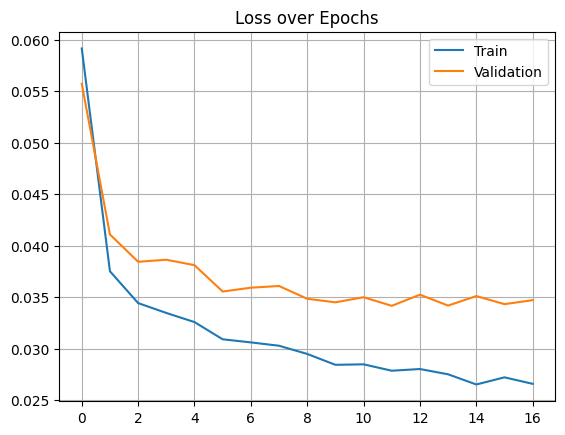

In [6]:

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title("Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()


### 🔹 6. Prediction vs Ground Truth (inversed from scaler)

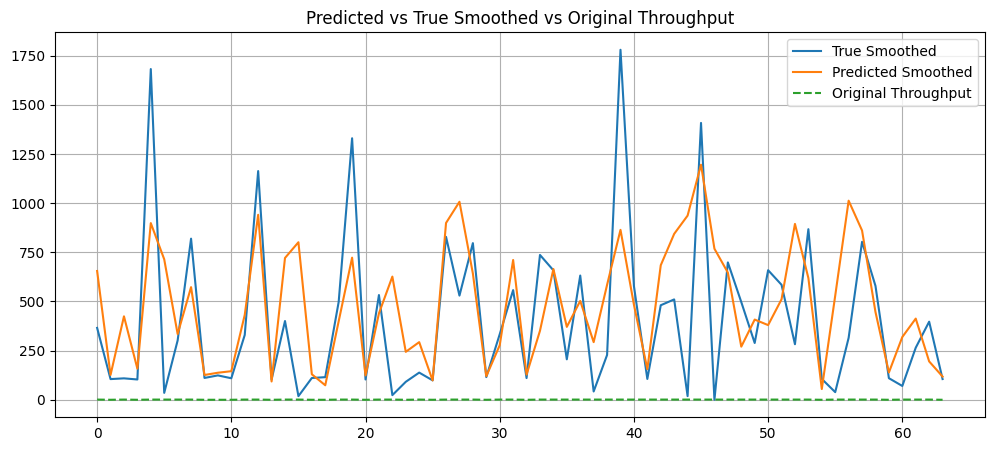

In [7]:

model.eval()
xbatch, ytrue = next(iter(val_dl))
with torch.no_grad():
    ypred = model(xbatch).squeeze().numpy()

# Inverse transform
ytrue_inv = target_scaler.inverse_transform(ytrue.numpy().reshape(-1, 1)).flatten()
ypred_inv = target_scaler.inverse_transform(ypred.reshape(-1, 1)).flatten()

# Original throughput for reference
original_throughput = xbatch[:, -1, df.columns.get_loc('Throughput') - 3].numpy()

plt.figure(figsize=(12,5))
plt.plot(ytrue_inv, label='True Smoothed')
plt.plot(ypred_inv, label='Predicted Smoothed')
plt.plot(original_throughput, label='Original Throughput', linestyle='--')
plt.title('Predicted vs True Smoothed vs Original Throughput')
plt.legend()
plt.grid(True)
plt.show()
